In [106]:
import pandas as pd
import gspread
import json
from oauth2client.service_account import ServiceAccountCredentials 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from japanmap import pref_names
from japanmap import picture
from japanmap import pref_code
from scipy import stats

In [64]:
#2つのAPIを記述しないとリフレッシュトークンを3600秒毎に発行し続けなければならない
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']

#認証情報設定
#ダウンロードしたjsonファイル名をクレデンシャル変数に設定（秘密鍵、Pythonファイルから読み込みしやすい位置に置く）
credentials = ServiceAccountCredentials.from_json_keyfile_name('spreadsheet-test-282700-cdf2cfae7e32.json', scope)

#OAuth2の資格情報を使用してGoogle APIにログインします。
gc = gspread.authorize(credentials)

#共有設定したスプレッドシートキーを変数[SPREADSHEET_KEY]に格納する。
SPREADSHEET_KEY = '10MFfRQTblbOpuvOs_yjIYgntpMGBg592dL8veXoPpp4'

#共有設定したスプレッドシートのワークシート1を開く
worksheet = gc.open_by_key(SPREADSHEET_KEY)
#取得するシート番号を指定
worksheet = worksheet.get_worksheet(1)

In [65]:
df = pd.DataFrame(worksheet.get_all_values())
df.columns = list(df.loc[0, :])
df.drop(0, inplace=True)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df[-5:]

,日付,日本国内 累計罹患者数,日本国内 新規罹患者数,北海道,青森県,岩手県,宮城県,秋田県,山形県,福島県,...,愛媛県,高知県,福岡県,佐賀県,長崎県,熊本県,大分県,宮崎県,鹿児島県,沖縄県
172,2020/07/05,19822,208,1,0,0,0,0,0,0,...,0,0,9,0,0,0,0,1,13,0
173,2020/07/06,19998,176,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,12,0
174,2020/07/07,20206,208,1,0,0,0,0,0,0,...,0,0,7,0,0,0,0,0,9,0
175,2020/07/08,20413,207,4,0,0,1,0,0,0,...,0,0,13,0,1,0,0,0,3,2
176,2020/07/09,20768,355,1,1,0,1,0,0,0,...,0,0,4,0,0,0,0,0,2,1


In [66]:
df.shape

(177, 50)

In [67]:
pref_code('神奈川')

14

In [68]:
#東京の直近5日間
df['東京都'][-5:]

172    111
173    102
174    106
175     75
176    224
Name: 東京都, dtype: object

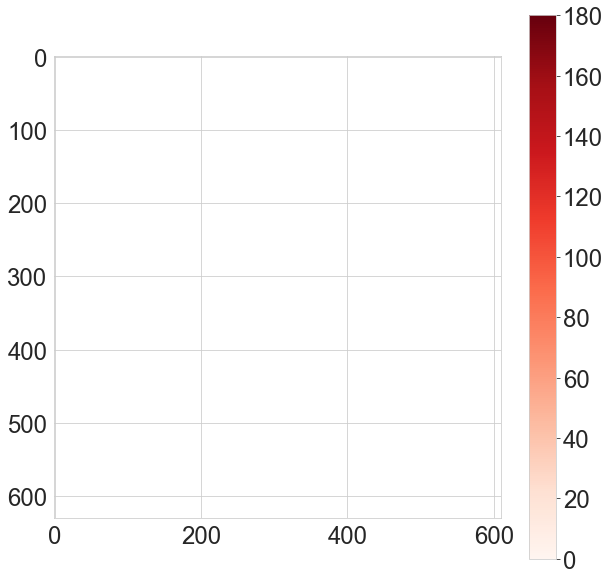

In [20]:
ims = []
fig, ax = plt.subplots(figsize=(10, 10))
#1レコードずつ取得し, 都道府県別にデータを可視化
#都道府県名:感染者数 のリスト作成
for row in df[1:].itertuples():
    pre_dict = {}
    for i in range(3, 50):
        pre_dict[df.columns[i]] = float(row[i+1])
    df_id = pd.DataFrame(index=pre_dict.keys())
    df_id["感染者数"] = pre_dict.values()
    df_id.head()
    cmap = plt.get_cmap('Reds')
    #norm = plt.Normalize(vmin=min(pre_dict.values()), vmax=max(pre_dict.values()))
    norm = plt.Normalize(vmin=0, vmax=180)
    fcol = lambda x: '#' + bytes(cmap(norm(x), bytes=True)[:3]).hex()
    title = ax.text(0.5, 1.01, row[1],
                     ha='center', va='bottom',
                     transform=ax.transAxes, fontsize='large')
    im = plt.imshow(picture(df_id.感染者数.apply(fcol)))
    ims.append([im, title])

ani = animation.ArtistAnimation(fig, ims, interval=400)
plt.colorbar(plt.cm.ScalarMappable(norm, cmap))
ani.save("output.gif", writer='pillow')

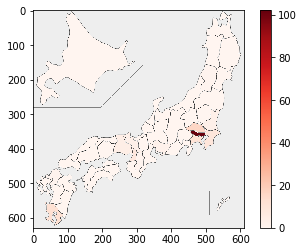

In [9]:
cmap = plt.get_cmap('Reds')
norm = plt.Normalize(vmin=min(pre_dict.values()), vmax=max(pre_dict.values()))
fcol = lambda x: '#' + bytes(cmap(norm(x), bytes=True)[:3]).hex()
plt.colorbar(plt.cm.ScalarMappable(norm, cmap))
plt.imshow(picture(df_id.感染者数.apply(fcol)))

In [81]:
#不要な列を消す
df = pd.DataFrame(worksheet.get_all_values())
df.columns = list(df.loc[0, :])
df.drop(0, inplace=True)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df = df.drop(df.index[0])
df.head()

,日付,日本国内 累計罹患者数,日本国内 新規罹患者数,北海道,青森県,岩手県,宮城県,秋田県,山形県,福島県,...,愛媛県,高知県,福岡県,佐賀県,長崎県,熊本県,大分県,宮崎県,鹿児島県,沖縄県
1,2020/01/16,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020/01/17,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020/01/18,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020/01/19,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2020/01/20,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
#整数型に変換
for i in range(1, 48):
    df[pref_names[i]] = df[pref_names[i]].astype(int)
df.dtypes

日付              object
日本国内\n累計罹患者数    object
日本国内\n新規罹患者数    object
北海道              int32
青森県              int32
岩手県              int32
宮城県              int32
秋田県              int32
山形県              int32
福島県              int32
茨城県              int32
栃木県              int32
群馬県              int32
埼玉県              int32
千葉県              int32
東京都              int32
神奈川県             int32
新潟県              int32
富山県              int32
石川県              int32
福井県              int32
山梨県              int32
長野県              int32
岐阜県              int32
静岡県              int32
愛知県              int32
三重県              int32
滋賀県              int32
京都府              int32
大阪府              int32
兵庫県              int32
奈良県              int32
和歌山県             int32
鳥取県              int32
島根県              int32
岡山県              int32
広島県              int32
山口県              int32
徳島県              int32
香川県              int32
愛媛県              int32
高知県              int32
福岡県              int32
佐賀県        

In [71]:
#累積感染者数の多い都道府県ベスト10
df_bar = df
df_bar = df_bar.drop(['日付', '日本国内\n累計罹患者数', '日本国内\n新規罹患者数'], axis=1)
df_bar.head()

,北海道,青森県,岩手県,宮城県,秋田県,山形県,福島県,茨城県,栃木県,群馬県,...,愛媛県,高知県,福岡県,佐賀県,長崎県,熊本県,大分県,宮崎県,鹿児島県,沖縄県
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
for i in range(1, df_bar.shape[0]):
    for j in range(1, 48):
        df_bar[pref_names[j]][i + 1] += df_bar[pref_names[j]][i]
df_bar[-5:]

,北海道,青森県,岩手県,宮城県,秋田県,山形県,福島県,茨城県,栃木県,群馬県,...,愛媛県,高知県,福岡県,佐賀県,長崎県,熊本県,大分県,宮崎県,鹿児島県,沖縄県
172,1277,27,0,98,16,70,82,183,87,155,...,82,74,877,47,18,49,60,18,98,142
173,1277,27,0,98,16,71,82,186,87,155,...,82,74,878,47,18,49,60,18,110,142
174,1278,27,0,98,16,71,82,187,88,155,...,82,74,885,47,18,49,60,18,119,142
175,1282,27,0,99,16,71,82,188,90,155,...,82,74,898,47,19,49,60,18,122,144
176,1283,28,0,100,16,71,82,189,90,155,...,82,74,902,47,19,49,60,18,124,145


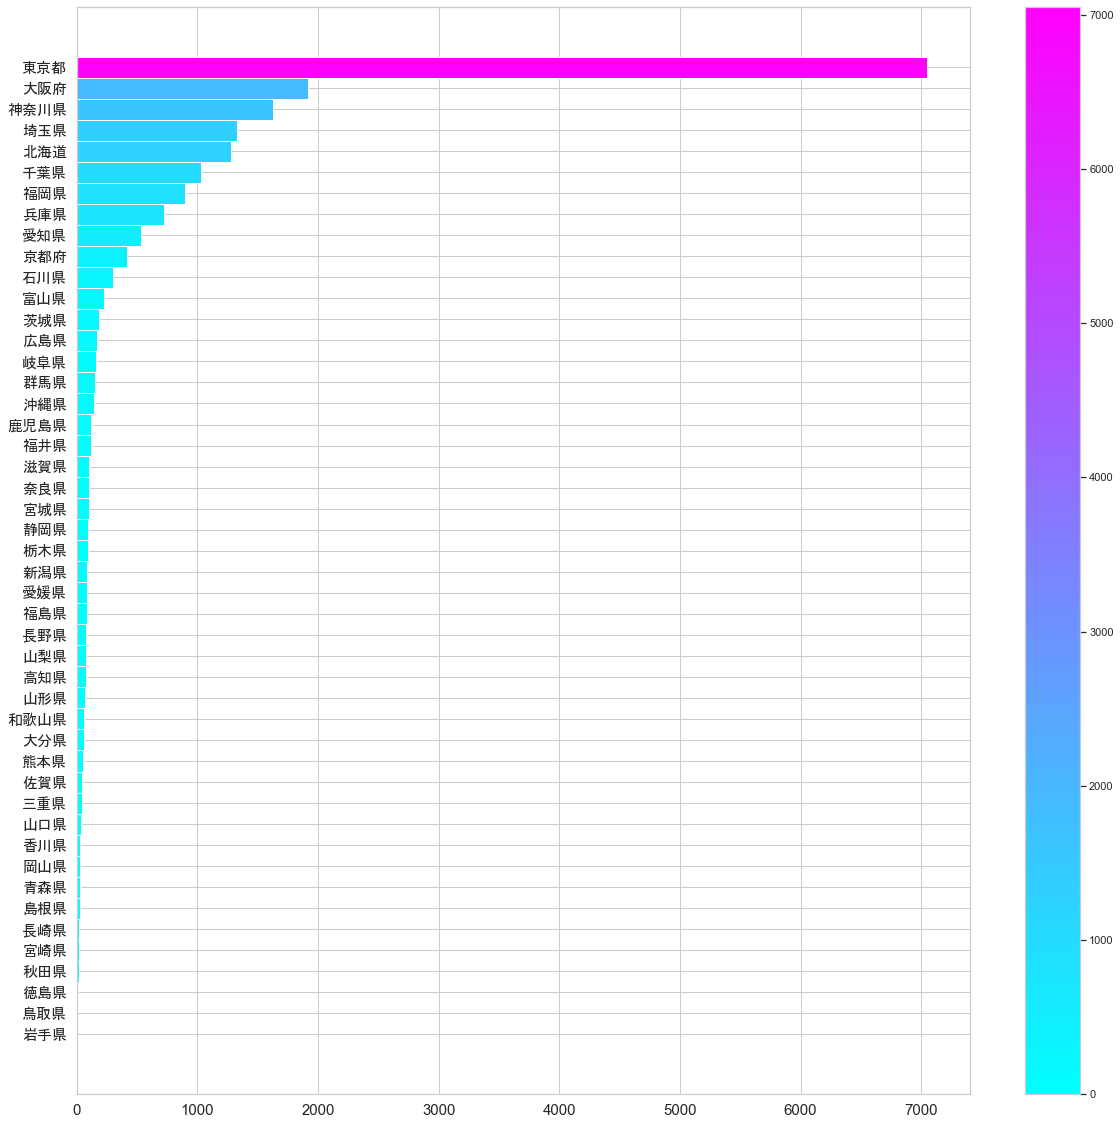

In [73]:
x = []
data = {}
for i in range(1, 48):
    x.append(i)
    data[pref_names[i]] = df_bar[pref_names[i]][df_bar.shape[0] - 1]

data = sorted(data.items(), key=lambda x:x[1])
y = [data[i][0] for i in range(len(data))]
values = [data[i][1] for i in range(len(data))]
sns.set(style='whitegrid')
plt.figure(figsize=(20, 20))
hist_max = np.max(values) 
cmap = plt.get_cmap('cool')
colorlist = [cmap(value/hist_max) for value in values]
norm = plt.Normalize(vmin=0, vmax=hist_max)
plt.barh(x, values, align="center", height=1, color=colorlist)
plt.yticks(x, y, fontname="MS Gothic")
plt.tick_params(labelsize=15)
plt.colorbar(plt.cm.ScalarMappable(norm, cmap))
plt.show()

In [83]:
#感染者数推移
df = df.loc[:, [u'日付', u'北海道', u'千葉県', u'東京都', u'埼玉県', u'神奈川県', u'愛知県', u'大阪府', u'兵庫県', u'福岡県', u'鹿児島県']]
df['日付'] = df['日付'].str.replace('/', '-')
df['日付'] = pd.to_datetime(df['日付'])
df = df.set_index(df['日付'])
df = df.drop(df.columns[0], axis=1)
df.head()

,北海道,千葉県,東京都,埼玉県,神奈川県,愛知県,大阪府,兵庫県,福岡県,鹿児島県
日付,,,,,,,,,,
2020-01-16,0,0,0,0,1,0,0,0,0,0
2020-01-17,0,0,0,0,0,0,0,0,0,0
2020-01-18,0,0,0,0,0,0,0,0,0,0
2020-01-19,0,0,0,0,0,0,0,0,0,0
2020-01-20,0,0,0,0,0,0,0,0,0,0


In [75]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

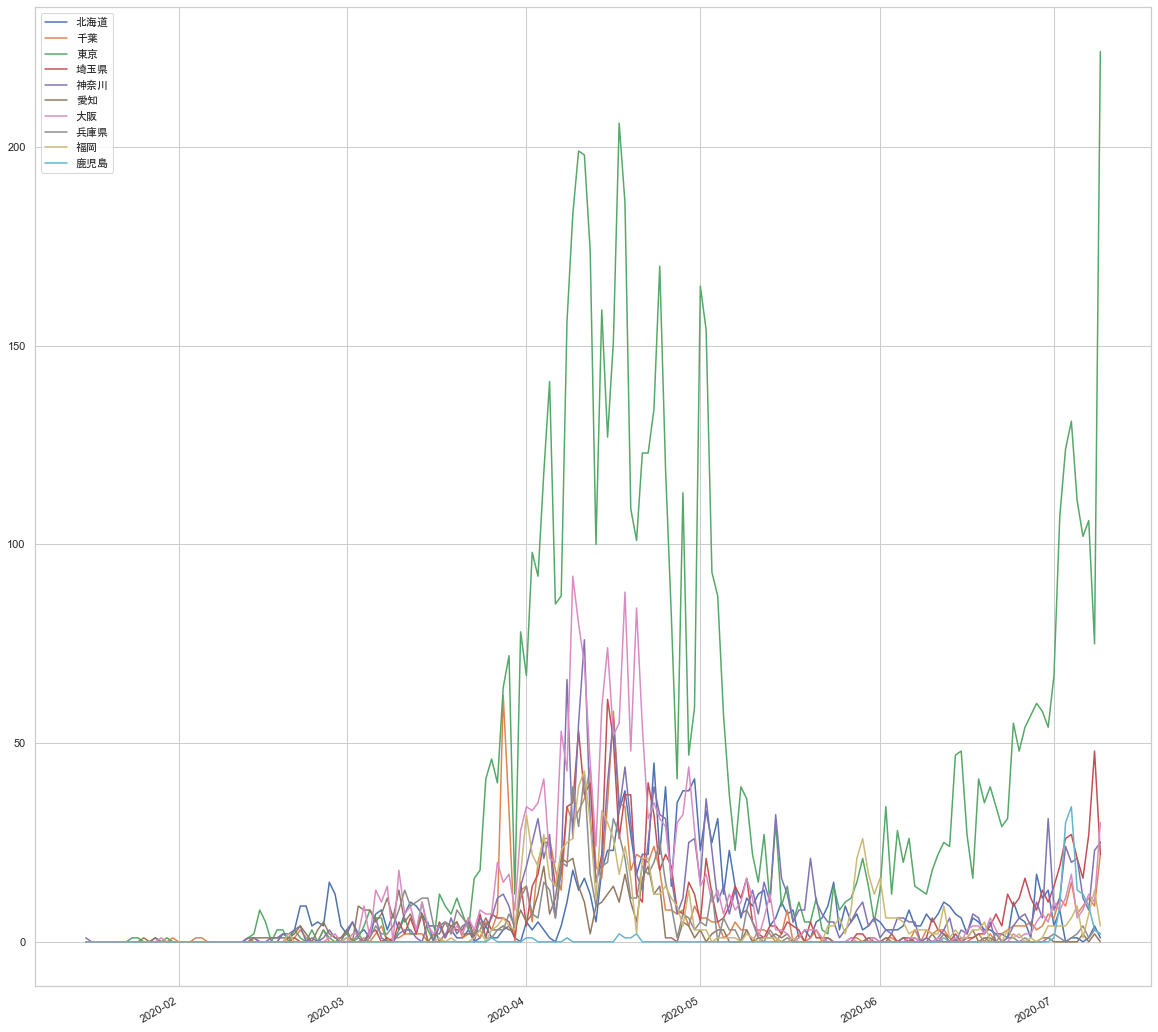

In [76]:
sns.set_style(style='whitegrid', rc=None)
fig = plt.figure(figsize=(20, 20))
plt.rcParams["font.size"] = 24

plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.plot(df.index, df['北海道'], label='北海道')
plt.plot(df.index, df['千葉県'], label='千葉')
plt.plot(df.index, df['東京都'], label='東京')
plt.plot(df.index, df['埼玉県'], label='埼玉県')
plt.plot(df.index, df['神奈川県'], label='神奈川')
plt.plot(df.index, df['愛知県'], label='愛知')
plt.plot(df.index, df['大阪府'], label='大阪')
plt.plot(df.index, df['兵庫県'], label='兵庫県')
plt.plot(df.index, df['福岡県'], label='福岡')
plt.plot(df.index, df['鹿児島県'], label='鹿児島')
plt.legend(prop={"family":"MS Gothic"})

In [77]:
#累計感染者数
df_dis = df
for i in range(df_dis.shape[0] - 1):
    df_dis['北海道'][i + 1] += df_dis['北海道'][i]
    df_dis['千葉県'][i + 1] += df_dis['千葉県'][i]
    df_dis['東京都'][i + 1] += df_dis['東京都'][i]
    df_dis['埼玉県'][i + 1] += df_dis['埼玉県'][i]
    df_dis['神奈川県'][i + 1] += df_dis['神奈川県'][i]
    df_dis['愛知県'][i + 1] += df_dis['愛知県'][i]
    df_dis['大阪府'][i + 1] += df_dis['大阪府'][i]
    df_dis['兵庫県'][i + 1] += df_dis['兵庫県'][i]
    df_dis['福岡県'][i + 1] += df_dis['福岡県'][i]
    df_dis['鹿児島県'][i + 1] += df_dis['鹿児島県'][i]
df_dis[-5:]

,北海道,千葉県,東京都,埼玉県,神奈川県,愛知県,大阪府,兵庫県,福岡県,鹿児島県
日付,,,,,,,,,,
2020-07-05,1277,1005,6765,1236,1584,528,1885,712,877,98
2020-07-06,1277,1014,6867,1252,1595,530,1893,716,878,110
2020-07-07,1278,1025,6973,1279,1603,530,1905,717,885,119
2020-07-08,1282,1034,7048,1327,1626,532,1915,720,898,122
2020-07-09,1283,1056,7272,1349,1651,532,1945,722,902,124


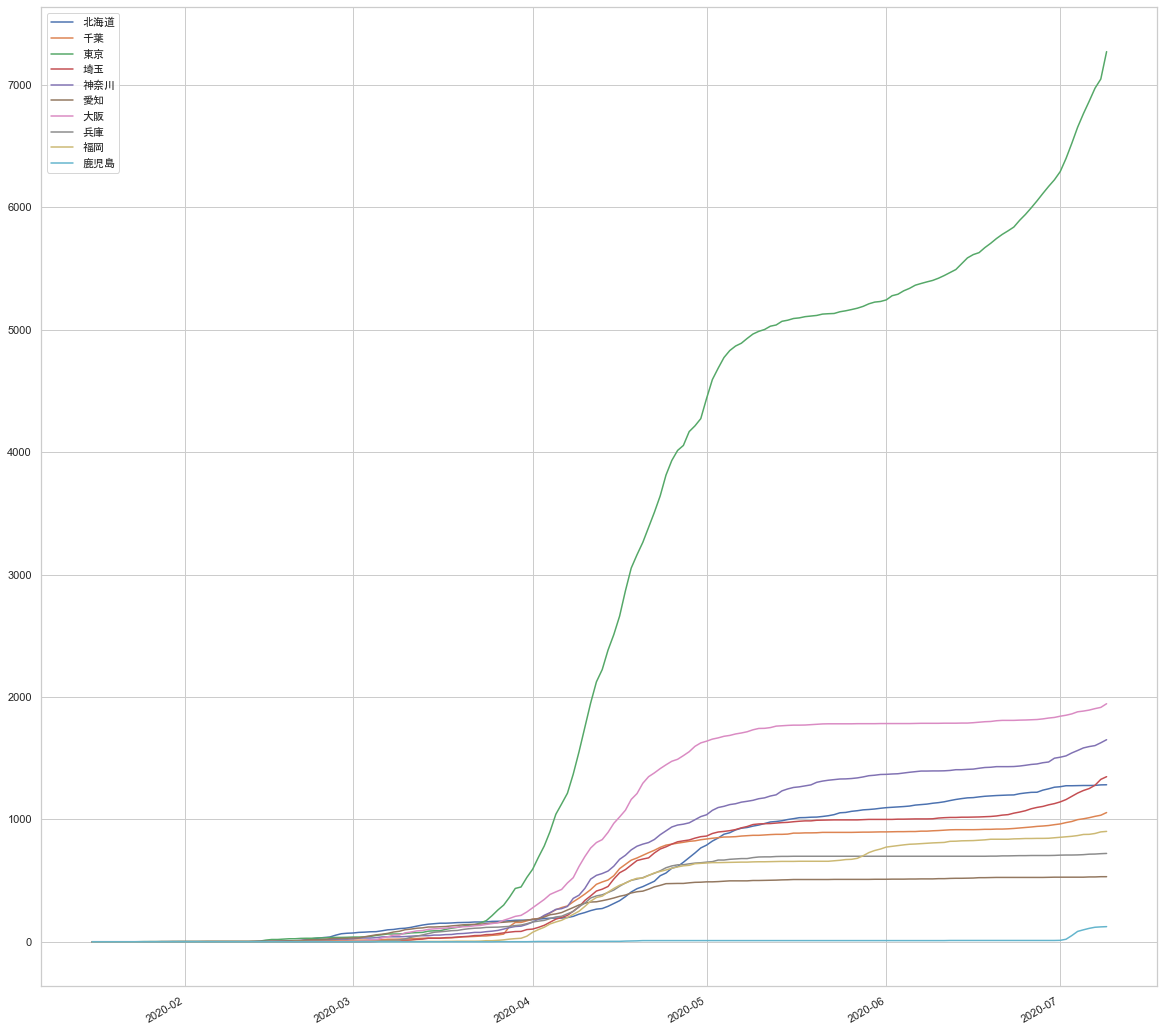

In [78]:
sns.set_style(style='whitegrid', rc=None)
fig = plt.figure(figsize=(20, 20))
plt.rcParams["font.size"] = 24

plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.plot(df_dis.index, df_dis['北海道'], label='北海道')
plt.plot(df_dis.index, df_dis['千葉県'], label='千葉')
plt.plot(df_dis.index, df_dis['東京都'], label='東京')
plt.plot(df_dis.index, df_dis['埼玉県'], label='埼玉')
plt.plot(df_dis.index, df_dis['神奈川県'], label='神奈川')
plt.plot(df_dis.index, df_dis['愛知県'], label='愛知')
plt.plot(df_dis.index, df_dis['大阪府'], label='大阪')
plt.plot(df_dis.index, df_dis['兵庫県'], label='兵庫')
plt.plot(df_dis.index, df_dis['福岡県'], label='福岡')
plt.plot(df_dis.index, df_dis['鹿児島県'], label='鹿児島')
plt.legend(prop={"family":"MS Gothic"})

In [96]:
df_growth = df
date = []
ave_list = []
for i in range(14, df_growth.shape[0] - 1, 14):
    date.append(df_growth.index[i])
    amount = 0
    for j in range(i - 14, i):
        amount += df_growth['東京都'][j]
    ave = amount/14
    ave_list.append(ave)
    
rate_list = [1]
for i in range(1, len(ave_list)):
    if ave_list[i-1] == 0: rate_list.append(ave_list[i]/0.1)
    else: rate_list.append(ave_list[i]/ave_list[i-1])

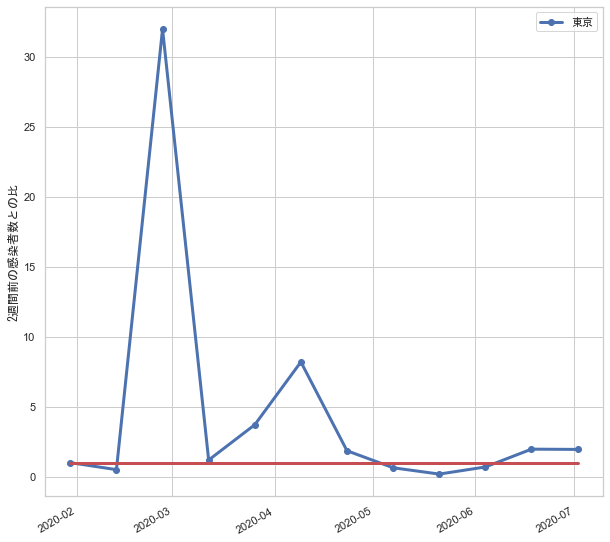

In [97]:
y = [1]*len(rate_list)
sns.set_style(style='whitegrid', rc=None)
fig = plt.figure(figsize=(10, 10))
plt.rcParams["font.size"] = 24

plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.plot(date, rate_list, 'b-o', label='東京', linewidth = 3)
plt.plot(date, y, color='r', linewidth = 3)
plt.ylabel('2週間前の感染者数との比', fontname="MS Gothic")
plt.legend(prop={"family":"MS Gothic"})

In [107]:
#伸び率の幾何平均
print(stats.gmean(rate_list))

1.6217565705394803
